# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import numpy as np
import os
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.color import rgb2gray
from skimage.util import crop

import datetime
import pytz

ModuleNotFoundError: No module named 'skimage'

We set the random seed so that the results don't vary drastically.

In [ ]:
from keras import backend as K
import tensorflow as tf

from numpy.random import seed
seed(23)
tf.random.set_seed(23)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:

train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/val.csv').readlines())
batch_size = 32

In [ ]:
train_doc[:3]

array(['WIN_20180907_16_56_18_Pro_Stop Gesture_new;Stop Gesture_new;2\n',
       'WIN_20180926_17_27_33_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_26_40_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n'],
      dtype='<U88')

Checking the overall image size.

In [ ]:
source_path= '/content/gdrive/MyDrive/Project_data/train'
indi_file= [(source_path + '/' + x.split(';')[0]) for x in train_doc]
img_shape=[]
for x in indi_file:
  imgs= os.listdir(x)
  for img in imgs:
    im= io.imread(x+'/'+ img)
    img_shape.append(im.shape)
    break
print(set(img_shape))

KeyboardInterrupt: ignored

As we could visualize there are two type of images

(120,160,3) & (360,360,3)

Plotting an image.

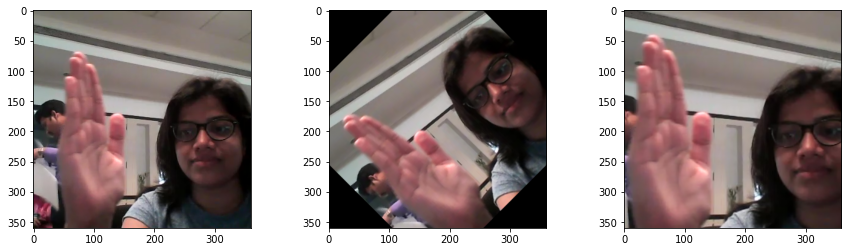

(360, 360, 3)


In [ ]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import transform as tf

imgg= '/content/gdrive/MyDrive/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00064.png'
image= io.imread(imgg)
shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

# translation by certain units
matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])

# rotation
rot_transforms =  tf.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = tf.warp(image, rot_matrix)

#scaling
scale_transforms = tf.AffineTransform(scale=(0.8, 0.8))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_in = tf.warp(image, scale_matrix)


f,ax= plt.subplots(1,3)
f.set_figwidth(15)
ax[0].imshow(image)
ax[1].imshow(rot_image)
ax[2].imshow(scale_image_zoom_in)

plt.show()


print(image.shape)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import transform as tf

def augment(image):
  #gray
  image= rgb2gray(image)

  shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
  # translation by certain units
  matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
  matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])
  
  #scaling
  scale_transforms = tf.AffineTransform(scale=(0.8, 0.8))
  scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
  scale_image_zoom_in = tf.warp(image, scale_matrix)

  aug_img= resize(scale_image_zoom_in, (image.shape[0],image.shape[1],3))

  return (aug_img)

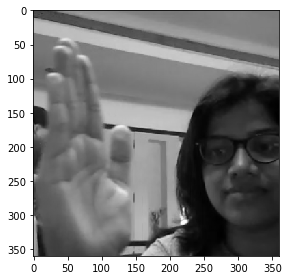

In [ ]:
imgg= '/content/gdrive/MyDrive/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00064.png'
image= io.imread(imgg)
io.imshow(augment(image))

In [ ]:
img_idx = [0,2,4,6,8,10,12,14,15,16,18,20,22,24,26,28]
def generator(source_path, folder_list, batch_size, ablation=None, augmentation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    if ablation is not None:
      folder_list= folder_list[:(ablation)]
    while True:
        t = np.random.permutation(folder_list)
        x= len(img_idx)
        y,z= 120,120
        num_batches = int(np.floor(len(t)/batch_size))
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # img_idx is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            if augmentation:
              batch_data_aug= np.zeros((batch_size,x,y,z,3))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape== (360,360,3):
                      image= crop(image, ((40,20),(30,30),(0,0)),copy=False)
                    resized_image= resize(image, (y,z))
                    batch_data[folder,idx,:,:,:] = np.float32(resized_image/255)
                    #batch_data[folder,idx,:,:,0] = (resized_image[:,:,0] - np.min(resized_image[:,:,0]))/(np.max(resized_image[:,:,0]) - np.min(resized_image[:,:,0]))
                    #batch_data[folder,idx,:,:,1] = (resized_image[:,:,1] - np.min(resized_image[:,:,1]))/(np.max(resized_image[:,:,1]) - np.min(resized_image[:,:,1]))
                    #batch_data[folder,idx,:,:,2] = (resized_image[:,:,2] - np.min(resized_image[:,:,2]))/(np.max(resized_image[:,:,2]) - np.min(resized_image[:,:,2]))
                    if augmentation:
                      aug_img= augment(resized_image)
                      batch_data_aug[folder,idx,:,:,:] = np.float32(aug_img/255)

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            if augmentation:
              batch_data=np.concatenate([batch_data,batch_data_aug])
              batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        rest_data = len(t) % (batch_size)
        batch_data = np.zeros((rest_data,x,y,z,3)) # img_idx is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((rest_data,5))
        if augmentation:
          batch_data_aug= np.zeros((rest_data,x,y,z,3))
        for i in range(rest_data):
          imgs= os.listdir(source_path+'/'+ t[-(rest_data-i)].split(';')[0])
          for idx,item in enumerate(img_idx):
            image = io.imread(source_path+'/'+ t[-(rest_data-i)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            if image.shape== (360,360,3):
              image= crop(image, ((40,20),(30,30),(0,0)),copy=False)
            resized_image= resize(image, (y,z))
            batch_data[i,idx,:,:,:] = np.float32(resized_image/255)
            #batch_data[i,idx,:,:,0] = (resized_image[:,:,0] - np.min(resized_image[:,:,0]))/(np.max(resized_image[:,:,0]) - np.min(resized_image[:,:,0]))
            #batch_data[i,idx,:,:,1] = (resized_image[:,:,1] - np.min(resized_image[:,:,1]))/(np.max(resized_image[:,:,1]) - np.min(resized_image[:,:,1]))
            #batch_data[i,idx,:,:,2] = (resized_image[:,:,2] - np.min(resized_image[:,:,2]))/(np.max(resized_image[:,:,2]) - np.min(resized_image[:,:,2]))
            if augmentation:
              aug_img= augment(resized_image)
              batch_data_aug[i,idx,:,:,:] = np.float32(aug_img/255)
          
          batch_labels[i, int(t[-(rest_data-i)].strip().split(';')[2])] = 1
        
        if augmentation:
          batch_data=np.concatenate([batch_data,batch_data_aug])
          batch_labels=np.concatenate([batch_labels,batch_labels])
        yield batch_data, batch_labels

        # write the code for the remaining data points which are left after full batches


In [ ]:
train_path = '/content/gdrive/MyDrive/Project_data/train/'
val_path = '/content/gdrive/MyDrive/Project_data/val/'

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Reshape, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, AveragePooling3D, Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

In [ ]:
batch_size

32

In [ ]:
def compile_model(model,epoch=20, ablation=None, learning_rate=0.001, store_model=False, augment=False):
  optimiser = optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  
  if augment:
    train_generator = generator(train_path, train_doc, batch_size, augmentation=True)
    if ablation is not None:
      train_generator = generator(train_path, train_doc, batch_size,augmentation=True, ablation=ablation)
  else:
    train_generator = generator(train_path, train_doc, batch_size)
    if ablation is not None:
      train_generator = generator(train_path, train_doc, batch_size, ablation=ablation)
  val_generator = generator(val_path, val_doc, batch_size)

  num_train_sequences = len(train_doc)
  if ablation is not None:
    num_train_sequences = ablation
  num_val_sequences = len(val_doc)
  
  LR = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2, verbose=0, 
                         mode='auto',min_delta=0.002, cooldown=0,min_lr=0)
  callbacks_list = [LR]

  if store_model==True:
    curr_dt_time= datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
    model_name = '/content/gdrive/MyDrive/Project_data/'+'model_init_' + str(curr_dt_time).split('.')[0] + '/'
    if not os.path.exists(model_name):
      os.mkdir(model_name)
      filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
      checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
      callbacks_list= [LR, checkpoint]


  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = int(num_val_sequences//batch_size) + 1
  
  history= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epoch, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, workers=1, initial_epoch=0)
  print('\n')
  print('*'*120)
  print('\n')
  
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
  axes[0].plot(history.history['loss'])   
  axes[0].plot(history.history['val_loss'])
  axes[0].legend(['loss','val_loss'])

  axes[1].plot(history.history['categorical_accuracy'])   
  axes[1].plot(history.history['val_categorical_accuracy'])
  axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
  plt.show()

In [ ]:
num_class=5

model= Sequential()
model.add(Conv3D(16, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(512, activation= 'relu'))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 60, 60, 32)     128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 4, 30, 30, 32)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 4, 30, 30, 64)    

We are taking only 100 data points from train dataset in order to know whether our model training is happening or not.

Let us now fit the model. This will start training the model on only ablation data to check the model is learning or not.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32
Epoch 1/5
4/4 [==============================] - 37s 12s/step - loss: 15.3322 - categorical_accuracy: 0.5907 - val_loss: 67.4781 - val_categorical_accuracy: 0.1800
Epoch 2/5
4/4 [==============================] - 35s 11s/step - loss: 5.6644 - categorical_accuracy: 0.6795 - val_loss: 52.2670 - val_categorical_accuracy: 0.1900
Epoch 3/5
4/4 [==============================] - 34s 11s/step - loss: 4.3351 - categorical_accuracy: 0.7337 - val_loss: 25.8219 - val_categorical_accuracy: 0.2000
Epoch 4/5
4/4 [==============================] - 31s 10s/step - loss: 0.7965 - categorical_accuracy: 0.8892 - val_loss: 17.6056 - val_categorical_accuracy: 0.1800
Epoch 5/5
4/4 [==============================] - 35s 11s/step - loss: 1.2595 - categorical_accuracy: 0.8953 - val_loss: 14.3255 - val_categorical_accuracy: 0.1900


******************************************************************

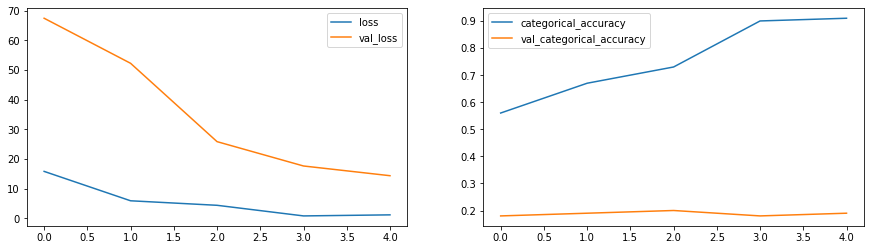

In [ ]:
compile_model(model, ablation=100, epoch=5)

In [ ]:
num_class=5

model= Sequential()
model.add(Conv3D(16, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(512, activation= 'relu'))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_21 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 60, 60, 32)     128       
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 4, 30, 30, 32)     0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 4, 30, 30, 64)    

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32
Epoch 1/5
4/4 [==============================] - 54s 17s/step - loss: 48.3545 - categorical_accuracy: 0.1672 - val_loss: 49.2103 - val_categorical_accuracy: 0.2200
Epoch 2/5
4/4 [==============================] - 50s 17s/step - loss: 38.6728 - categorical_accuracy: 0.3207 - val_loss: 139.0434 - val_categorical_accuracy: 0.2100
Epoch 3/5
4/4 [==============================] - 51s 17s/step - loss: 17.6764 - categorical_accuracy: 0.5008 - val_loss: 217.8085 - val_categorical_accuracy: 0.1000
Epoch 4/5
4/4 [==============================] - 46s 15s/step - loss: 9.1723 - categorical_accuracy: 0.6470 - val_loss: 155.9548 - val_categorical_accuracy: 0.2000
Epoch 5/5
4/4 [==============================] - 50s 17s/step - loss: 7.3007 - categorical_accuracy: 0.7018 - val_loss: 133.9843 - val_categorical_accuracy: 0.1800


************************************************************

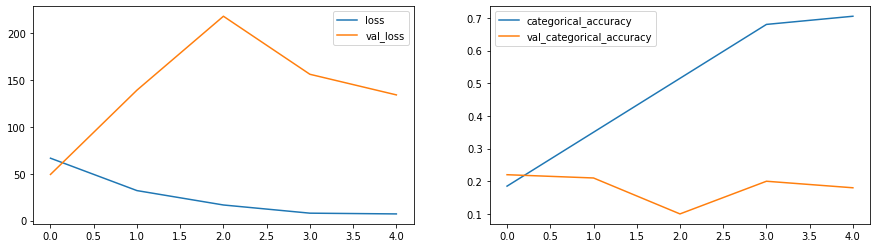

In [ ]:
compile_model(model, ablation=100, epoch=5, augment=True)

Now will run the model with entire dataset with 20 epochs.

In [ ]:
num_class=5

model= Sequential()
model.add(Conv3D(16, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation= 'relu'))
model.add(Dropout(0.40))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 60, 60, 32)     128       
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 4, 30, 30, 32)    

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - 1413s 71s/step - loss: 32.3509 - categorical_accuracy: 0.2800 - val_loss: 51.1808 - val_categorical_accuracy: 0.1800
Epoch 2/20
21/21 [==============================] - 122s 6s/step - loss: 5.1314 - categorical_accuracy: 0.5499 - val_loss: 20.8401 - val_categorical_accuracy: 0.2100
Epoch 3/20
21/21 [==============================] - 120s 6s/step - loss: 1.8288 - categorical_accuracy: 0.6110 - val_loss: 19.8258 - val_categorical_accuracy: 0.2400
Epoch 4/20
21/21 [==============================] - 115s 6s/step - loss: 1.3597 - categorical_accuracy: 0.6021 - val_loss: 24.8603 - val_categorical_accuracy: 0.2500
Epoch 5/20
21/21 [==============================] - 119s 6s/step - loss: 0.7771 - categorical_accuracy: 0.7097 - val_loss: 23.3253 - val_categorical_accuracy: 0.3200
Epoch 6/20
21/21 [==============================] -

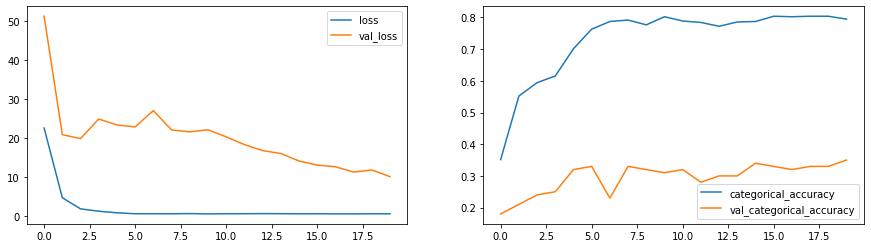

In [ ]:
compile_model(model, epoch=20)

Trying a different architecture.

In [ ]:
num_class=5

model= Sequential()
model.add(Conv3D(16, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(256, activation= 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128, activation= 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 60, 60, 32)     128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 4, 30, 30, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 4, 30, 30, 64)    

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - 120s 6s/step - loss: 1.8437 - categorical_accuracy: 0.3385 - val_loss: 1.6037 - val_categorical_accuracy: 0.2200
Epoch 2/20
21/21 [==============================] - 117s 6s/step - loss: 0.9112 - categorical_accuracy: 0.6485 - val_loss: 2.7409 - val_categorical_accuracy: 0.2400
Epoch 3/20
21/21 [==============================] - 118s 6s/step - loss: 0.6515 - categorical_accuracy: 0.7658 - val_loss: 9.3889 - val_categorical_accuracy: 0.2100
Epoch 4/20
21/21 [==============================] - 112s 6s/step - loss: 0.5019 - categorical_accuracy: 0.8160 - val_loss: 11.7026 - val_categorical_accuracy: 0.1600
Epoch 5/20
21/21 [==============================] - 116s 6s/step - loss: 0.4120 - categorical_accuracy: 0.8676 - val_loss: 14.3492 - val_categorical_accuracy: 0.1600
Epoch 6/20
21/21 [==============================] - 117s 

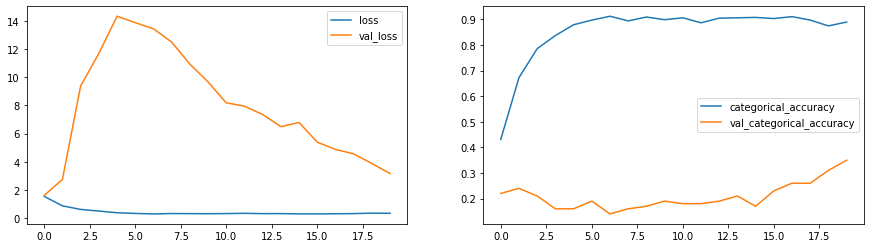

In [ ]:
compile_model(model, epoch=20)

In [ ]:
num_class=5

model= Sequential()
model.add(Conv3D(16, (2,2,2), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, (2,2,2), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (2,2,2), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation= 'relu'))
model.add(Dropout(0.40))

model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 60, 60, 32)     128       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 4, 30, 30, 32)    

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
21/21 [==============================] - 233s 12s/step - loss: 53.4830 - categorical_accuracy: 0.2547 - val_loss: 5.2257 - val_categorical_accuracy: 0.2100
Epoch 2/20
21/21 [==============================] - 233s 12s/step - loss: 3.9276 - categorical_accuracy: 0.4498 - val_loss: 23.8731 - val_categorical_accuracy: 0.2200
Epoch 3/20
21/21 [==============================] - 230s 11s/step - loss: 1.4218 - categorical_accuracy: 0.4603 - val_loss: 25.9338 - val_categorical_accuracy: 0.3200
Epoch 4/20
21/21 [==============================] - 228s 11s/step - loss: 1.0979 - categorical_accuracy: 0.5376 - val_loss: 30.0319 - val_categorical_accuracy: 0.3600
Epoch 5/20
21/21 [==============================] - 231s 12s/step - loss: 1.0338 - categorical_accuracy: 0.5722 - val_loss: 37.4156 - val_categorical_accuracy: 0.3300
Epoch 6/20
21/21 [==============================] - 232s 12s/step - loss: 0.9852 - categorical_accuracy: 0.5571 - val_loss: 43.9898 - val_categorical_accuracy: 0.290

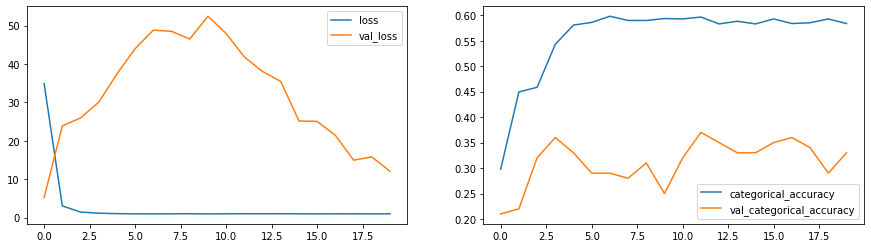

In [ ]:
compile_model(model, epoch=20, augment=True)

Now let's build a CNN+RNN model using ResNet architecture.

In [ ]:
num_class=5

# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape= (120,120,3))
    
# freeze the layers in base model
for layer in base_model.layers:
  layer.trainable = False

model= Sequential()
model.add(TimeDistributed(base_model, input_shape=(len(img_idx),120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

94773248/94765736 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 16, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 32768)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 16, 128)           12632832  
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 128)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_______________________________________________________

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
7/7 [==============================] - 57s 8s/step - loss: 4.4174 - categorical_accuracy: 0.3099 - val_loss: 3.5074 - val_categorical_accuracy: 0.2200
Epoch 2/5
7/7 [==============================] - 50s 8s/step - loss: 3.2335 - categorical_accuracy: 0.2213 - val_loss: 2.1742 - val_categorical_accuracy: 0.2300
Epoch 3/5
7/7 [==============================] - 49s 8s/step - loss: 2.2693 - categorical_accuracy: 0.2073 - val_loss: 2.4898 - val_categorical_accuracy: 0.1900
Epoch 4/5
7/7 [==============================] - 46s 8s/step - loss: 2.4054 - categorical_accuracy: 0.1748 - val_loss: 1.9310 - val_categorical_accuracy: 0.2000
Epoch 5/5
7/7 [==============================] - 49s 8s/step - loss: 2.5424 - categorical_accuracy: 0.1810 - val_loss: 2.0117 - val_categorical_accuracy: 0.2600


************************************************************************************************************************




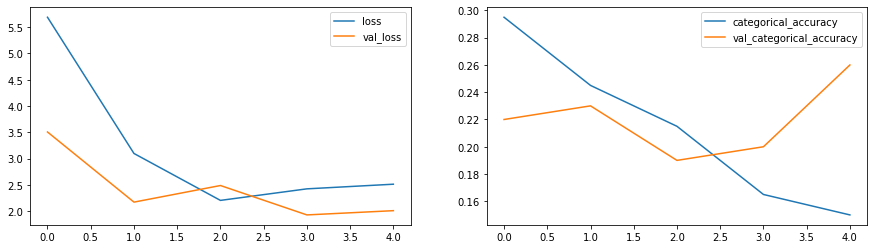

In [ ]:
compile_model(model, epoch=5, ablation=200 )

In [ ]:
num_class=5

# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape= (120,120,3))
    
# freeze the layers in base model
for layer in base_model.layers:
  layer.trainable = False

model= Sequential()
model.add(TimeDistributed(base_model, input_shape=(len(img_idx),120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 16, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 32768)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 16, 128)           12632832  
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 128)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)              

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
7/7 [==============================] - 92s 14s/step - loss: 5.2315 - categorical_accuracy: 0.1772 - val_loss: 2.3602 - val_categorical_accuracy: 0.2300
Epoch 2/5
7/7 [==============================] - 83s 14s/step - loss: 2.9248 - categorical_accuracy: 0.1737 - val_loss: 2.7247 - val_categorical_accuracy: 0.1800
Epoch 3/5
7/7 [==============================] - 82s 14s/step - loss: 2.9055 - categorical_accuracy: 0.2142 - val_loss: 2.1702 - val_categorical_accuracy: 0.2400
Epoch 4/5
7/7 [==============================] - 78s 13s/step - loss: 2.2921 - categorical_accuracy: 0.1987 - val_loss: 1.9807 - val_categorical_accuracy: 0.2400
Epoch 5/5
7/7 [==============================] - 82s 14s/step - loss: 2.2408 - categorical_accuracy: 0.2358 - val_loss: 2.1613 - val_categorical_accuracy: 0.2100


************************************************************************************************************************




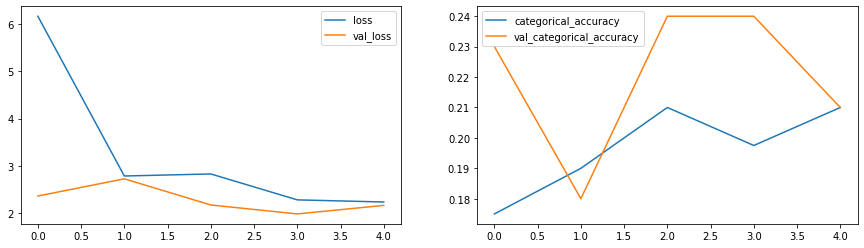

In [ ]:
compile_model(model, epoch=5, ablation=200, augment= True)

Now when the model is running fine, we will try different parametres to boost the accuracy

We start with the below architecture with intentionally skipping the save model callback.

In [ ]:
num_class=5

# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape= (120,120,3))
    
# freeze the layers in base model
for layer in base_model.layers:
  layer.trainable = False

model= Sequential()
model.add(TimeDistributed(base_model, input_shape=(len(img_idx),120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 32768)         0         
_________________________________________________________________
gru (GRU)                    (None, 16, 128)           12632832  
_________________________________________________________________
dropout (Dropout)            (None, 16, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________

Now we will run the model for 20 epochs.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - 3384s 168s/step - loss: 5.2962 - categorical_accuracy: 0.2035 - val_loss: 2.0599 - val_categorical_accuracy: 0.1800
Epoch 2/20
21/21 [==============================] - 236s 12s/step - loss: 2.2600 - categorical_accuracy: 0.1971 - val_loss: 1.8749 - val_categorical_accuracy: 0.2500
Epoch 3/20
21/21 [==============================] - 232s 12s/step - loss: 1.9724 - categorical_accuracy: 0.2041 - val_loss: 1.5226 - val_categorical_accuracy: 0.2900
Epoch 4/20
21/21 [==============================] - 229s 11s/step - loss: 1.8714 - categorical_accuracy: 0.2659 - val_loss: 1.9183 - val_categorical_accuracy: 0.2700
Epoch 5/20
21/21 [==============================] - 229s 11s/step - loss: 1.9482 - categorical_accuracy: 0.2847 - val_loss: 1.6607 - val_categorical_accuracy: 0.3300
Epoch 6/20
21/21 [==============================] - 

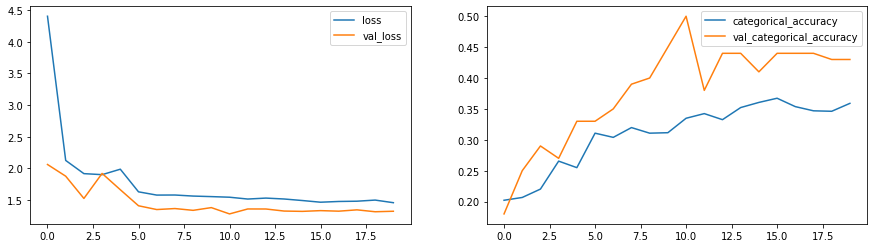

In [ ]:
compile_model(model, epoch=20, augment=True)

Now we will try with a different architecture as the above model accuracy is very low.

In [ ]:
num_class=5

# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape= (120,120,3))
    
# freeze the layers in base model
for layer in base_model.layers:
  layer.trainable = False

model= Sequential()
model.add(TimeDistributed(base_model, input_shape=(len(img_idx),120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(1024, return_sequences=True))
model.add(Dense(1024))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 32768)         0         
_________________________________________________________________
gru (GRU)                    (None, 16, 1024)          103815168 
_________________________________________________________________
dense (Dense)                (None, 16, 1024)          1049600   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
21/21 [==============================] - 3984s 198s/step - loss: 99.8978 - categorical_accuracy: 0.2006 - val_loss: 14.6917 - val_categorical_accuracy: 0.1800
Epoch 2/20
21/21 [==============================] - 232s 12s/step - loss: 13.4474 - categorical_accuracy: 0.2238 - val_loss: 5.2388 - val_categorical_accuracy: 0.2600
Epoch 3/20
21/21 [==============================] - 231s 11s/step - loss: 4.0259 - categorical_accuracy: 0.1826 - val_loss: 1.9125 - val_categorical_accuracy: 0.1900
Epoch 4/20
21/21 [==============================] - 226s 11s/step - loss: 2.1663 - categorical_accuracy: 0.2017 - val_loss: 2.0219 - val_categorical_accuracy: 0.2200
Epoch 5/20
21/21 [==============================] - 230s 11s/step - loss: 1.9476 - categorical_accuracy: 0.2311 - val_loss: 1.5495 - val_categorical_accuracy: 0.2600
Epoch 6/20
21/21 [==============================] - 231s 11s/step - loss: 1.5617 - categorical_accuracy: 0.3086 - val_loss: 1.4909 - val_categorical_accuracy: 0.2700

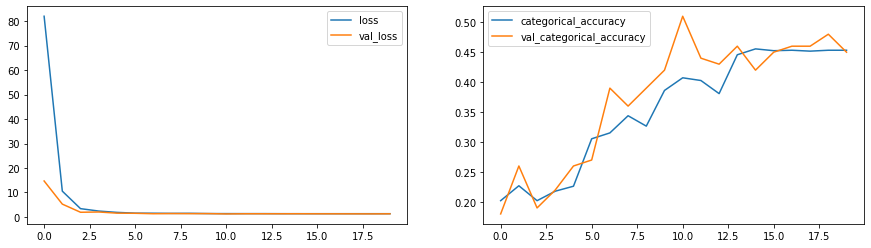

In [ ]:
compile_model(model, epoch=20, augment=True)

In [ ]:
num_class=5

# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape= (120,120,3))
    
# freeze the layers in base model
for layer in base_model.layers:
  layer.trainable = False

model= Sequential()
model.add(TimeDistributed(base_model, input_shape=(len(img_idx),120,120,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Flatten()))
model.add(GRU(128, return_sequences=False))
model.add(Dense(512))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 16, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 4, 4, 2048)    8192      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 2, 2, 2048)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 8192)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               3195648   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
21/21 [==============================] - 239s 12s/step - loss: 2.0334 - categorical_accuracy: 0.2584 - val_loss: 1.5864 - val_categorical_accuracy: 0.2100
Epoch 2/20
21/21 [==============================] - 231s 12s/step - loss: 1.4158 - categorical_accuracy: 0.3708 - val_loss: 1.4195 - val_categorical_accuracy: 0.3700
Epoch 3/20
21/21 [==============================] - 231s 11s/step - loss: 1.1891 - categorical_accuracy: 0.5196 - val_loss: 1.6172 - val_categorical_accuracy: 0.2400
Epoch 4/20
21/21 [==============================] - 227s 11s/step - loss: 1.1812 - categorical_accuracy: 0.4830 - val_loss: 1.3413 - val_categorical_accuracy: 0.4700
Epoch 5/20
21/21 [==============================] - 230s 11s/step - loss: 1.0669 - categorical_accuracy: 0.5710 - val_loss: 1.4173 - val_categorical_accuracy: 0.4200
Epoch 6/20
21/21 [==============================] - 231s 12s/step - loss: 0.9686 - categorical_accuracy: 0.6111 - val_loss: 1.2761 - val_categorical_accuracy: 0.5400
Epoc

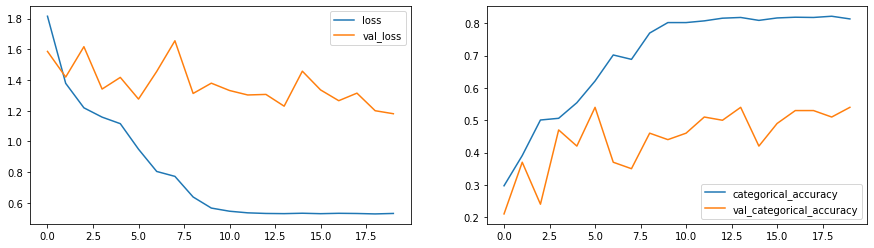

In [ ]:
compile_model(model, epoch=20, augment=True)

In [ ]:
num_class=5

base_model = Sequential()
base_model.add(Conv2D(16, (3, 3) , padding='same', activation='relu',input_shape= (120,120,3)))
base_model.add(BatchNormalization())
base_model.add((MaxPooling2D((2, 2))))
        
base_model.add(Conv2D(32, (3, 3) , padding='same', activation='relu'))
base_model.add(BatchNormalization())
base_model.add(MaxPooling2D((2, 2)))
        
base_model.add(Conv2D(64, (3, 3) , padding='same', activation='relu'))
base_model.add(BatchNormalization())
base_model.add(MaxPooling2D((2, 2)))

model= Sequential()
model.add(TimeDistributed(base_model, input_shape=(len(img_idx),120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(256, return_sequences=False))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 15, 15, 64)    24032     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 14400)         0         
_________________________________________________________________
gru (GRU)                    (None, 256)               11257344  
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 11,348,453
Trainable params: 11,348,229
Non-trainable params: 224
________________________________________

Source path =  /content/gdrive/MyDrive/Project_data/train/ ; batch size = 32


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
21/21 [==============================] - 3151s 157s/step - loss: 2.3452 - categorical_accuracy: 0.3346 - val_loss: 2.7574 - val_categorical_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 2.75743, saving model to /content/gdrive/MyDrive/Project_data/model_init_2021-02-02 11:01:05/model-00001-1.81253-0.38160-2.75743-0.20000.h5
Epoch 2/20
21/21 [==============================] - 233s 12s/step - loss: 1.0729 - categorical_accuracy: 0.5529 - val_loss: 3.5858 - val_categorical_accuracy: 0.1500

Epoch 00002: val_loss did not improve from 2.75743
Epoch 3/20
21/21 [==============================] - 231s 12s/step - loss: 0.8213 - categorical_accuracy: 0.6744 - val_loss: 3.7068 - val_categorical_accuracy: 0.2600

Epoch 00003: val_loss did not improve from 2.75743
Epoch 4/20
21/21 [==============================] - 227s 11s/step - loss: 0.5759 - categorical_accuracy: 0.8089 - val_loss: 3.7995 - val_categorical_accuracy: 0.2800

Epoch 00004: val_loss did not improve from 2.

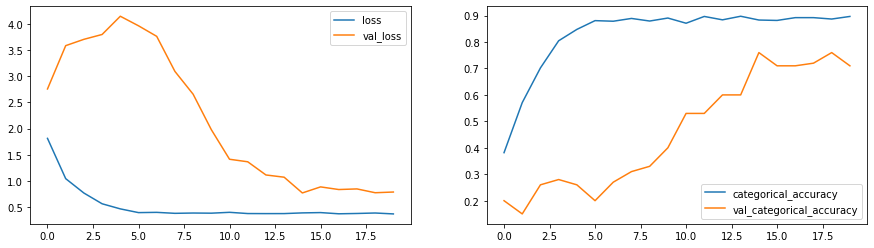

In [ ]:
compile_model(model, epoch=20, augment=True,store_model=True)